In [1]:
# Define model
import keras.layers as L
import keras.losses as losses
import keras.models as M
import keras.optimizers as opt
from keras.utils import to_categorical

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy 
import re
from sklearn import cross_validation, metrics
import seaborn as sns
%matplotlib inline

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Plot settings
plt.style.use('seaborn-dark-palette')
plt.interactive(True)
plt.rcParams['figure.figsize'] = (20, 8)

In [55]:
df = pd.read_csv('../../data/1900-01-01-2019-02-18-India.csv')

In [56]:
# GLoVE vector dictionary
vector = None

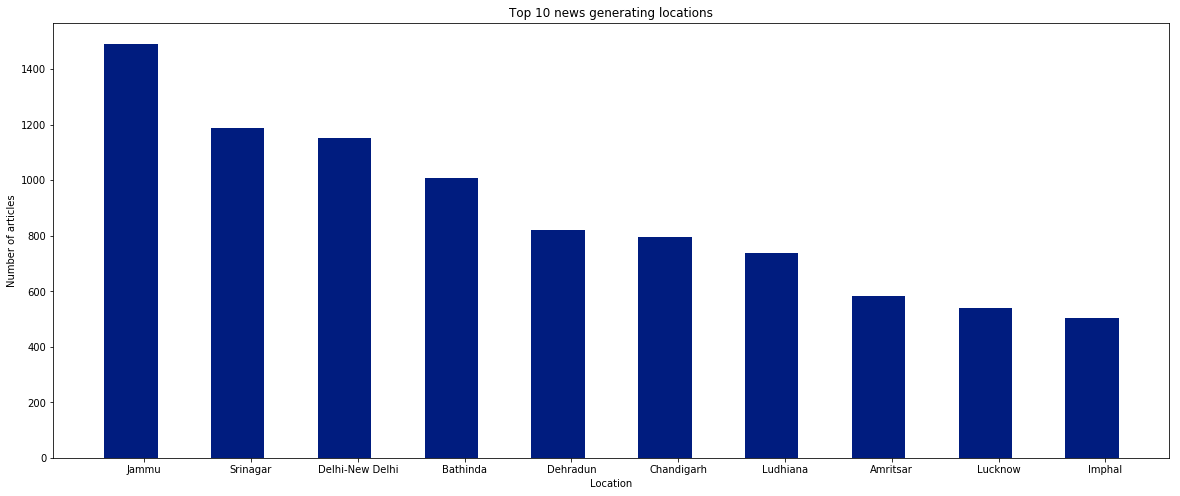

In [57]:
counter = Counter(df.location)
counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
counter = np.array(counter)

places, counts = counter[:, 0].tolist(), counter[:, 1].astype(np.float32)
indices = np.arange(len(counts))
width = 1

plt.xlabel("Location")
plt.ylabel("Number of articles")
plt.interactive(True)

plt.xticks(indices + 0.125, places)
plt.title("Top 10 news generating locations")
_ = plt.bar(indices, counts, 0.5)

In [58]:
df['event_date'] = pd.to_datetime(df['event_date'])
df.sort_values(by=['event_date'], inplace=True)

In [59]:
dates = pd.date_range(start=df.iloc[0]['event_date'], end=df.iloc[-1]['event_date'])
print("Number of days -", len(dates))

Number of days - 1136


In [60]:
dates[0], dates[-1]

(Timestamp('2016-01-01 00:00:00', freq='D'),
 Timestamp('2019-02-09 00:00:00', freq='D'))

In [61]:
df = df[df['location'] == "Chandigarh"]

num_events = np.zeros(len(dates))
i = 0
for date in dates:
    num_events[i] += len(df[df['event_date'] == date])
    i += 1

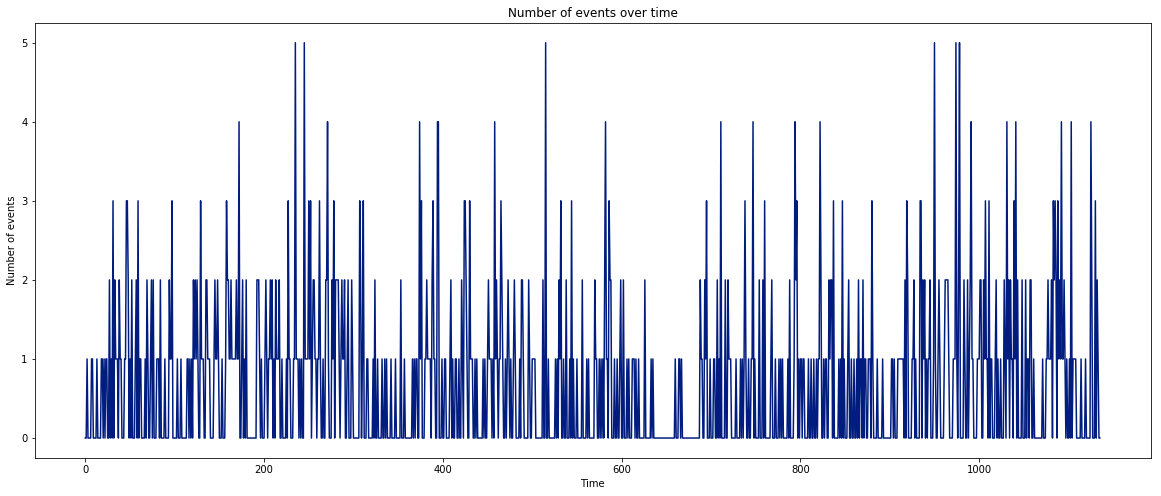

In [62]:
plt.title("Number of events over time")
plt.xlabel("Time")
plt.ylabel("Number of events")
_ = plt.plot(num_events)

In [63]:
news_articles = df.notes

In [64]:
def get_glove_dict():
    """
    Inputs - None
    
    Returns - Dict below
    
    Create a dict with word as key and word vector as value
    """
    d = {}
    f = open("../../glove_vectors/glove.6B.300d.txt", 'r')
    for row in f:
        row = row.replace('\n', '').split(" ")
        word = row[0]
        vector = np.array([float(x) for x in row[1:]])
        d[word] = vector
    f.close()
    return d

def generate_labels(num_events, num_days=2, days_window=2):
    """
    Inputs - 
        num_events - as generated as above 
        num_days - the number of days to after which we 
                   look for the occurence of an event.
                   Basically, the future
        day_window - If an event occurs in a window of days
                     after num_days
    
    Returns - Returns labels generated as below
    
    Generate labels by using the future events, basically
    look-ahead to create labels. If an event occurs from 
    i to i + num_days, then label is 1.0 else 0.0
    """
    n = len(num_events)
    labels = np.zeros(n - num_days - days_window)
    for i in range(n - num_days - days_window):
        labels[i] = 1.0 if sum(num_events[i + num_days: i + num_days + days_window] > 0) else 0.0
    return labels
    

In [65]:
if vector is None:
    vector = get_glove_dict()

In [66]:
labels = generate_labels(num_events)

In [67]:
print(labels.shape)

(1132,)


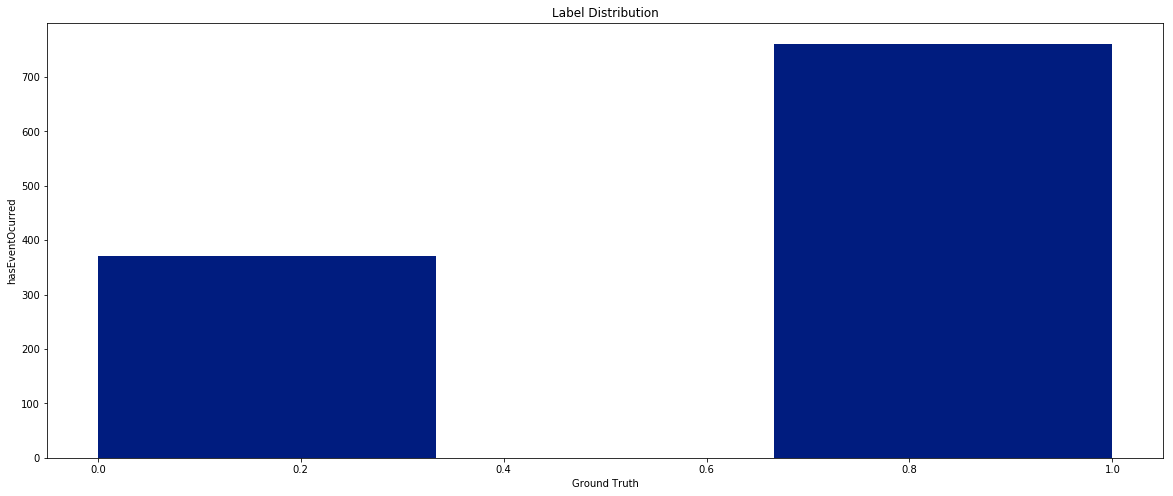

In [68]:
plt.title('Label Distribution')
plt.xlabel('Ground Truth')
plt.ylabel('hasEventOcurred')
_ = plt.hist(labels, bins=3, range=(0, 1))

In [69]:
# Tokenizer
nlp = spacy.load('en_core_web_sm')

# Generate sentence vectors
sentence_vectors = []
regexp = r'/[.,\/#!$%\^&\*;:{}=\-_`~()]/g'
num_sentences = len(news_articles)

for i, sentence in enumerate(news_articles):
    if i % 100 == 0:
        print (i, " / ", num_sentences, "done!")
    tokens = [t.text.lower() for t in nlp(sentence)]
    temp = []
    for token in tokens:
        vec = vector.get(token)
        if vec is None:
            vec = vector['unk']
        temp.append(vec)
    sentence_vectors.append(temp)
            

0  /  795 done!
100  /  795 done!
200  /  795 done!
300  /  795 done!
400  /  795 done!
500  /  795 done!
600  /  795 done!
700  /  795 done!


In [70]:
# For the sentence vector, currently, simply just use average of all words vectors
for i, vecs in enumerate(sentence_vectors):
    sentence_vectors[i] = np.mean(vecs, axis=0)

In [71]:
sentence_vectors = np.array(sentence_vectors)
print("Sentence vector shape -", sentence_vectors.shape)

vector_dim = sentence_vectors.shape[-1]

Sentence vector shape - (795, 300)


In [72]:
df.index = np.arange(len(df))
df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,2032925,356,IND50,50.0,2016-01-03,2016,1,Riots/Protests,Protesters (India),Labour Group (India),...,Chandigarh,30.7362,76.7884,1,The Tribune,Subnational,Members of the Punjab State Veterinary Inspect...,0,1542756338,IND
1,2559030,356,IND167,167.0,2016-01-08,2016,1,Riots/Protests,Rioters (India),IYC: Indian Youth Congress,...,Chandigarh,30.7362,76.7884,1,The Pioneer (India),National,"Youth Congress members clashed with police, de...",0,1546889906,IND
2,2017849,356,IND207,207.0,2016-01-09,2016,1,Riots/Protests,Protesters (India),NaN,...,Chandigarh,30.7362,76.7884,1,The Tribune,Subnational,Shalimar Mall allotters hold a protest in Sect...,0,1542756324,IND
3,2026670,356,IND310,310.0,2016-01-14,2016,1,Riots/Protests,Protesters (India),NaN,...,Chandigarh,30.7362,76.7884,1,The Tribune,Subnational,Hundreds of auto-rickshaw drivers staged a pro...,0,1542756332,IND
4,2032141,356,IND413,413.0,2016-01-19,2016,1,Riots/Protests,Protesters (India),Teachers (India),...,Chandigarh,30.7362,76.7884,3,The Tribune,Subnational,In response to a call given by the Punjab and ...,0,1542756337,IND


In [74]:
vec_date = []
for date in dates:
    temp_df = df[df['event_date'] == date]
    if len(temp_df) == 0:
        vec_date.append(np.zeros(vector_dim))

    else:
        indices = list(temp_df.index)
        vec_date_temp = np.mean(sentence_vectors[indices].reshape(-1, vector_dim), axis=0)
        vec_date.append(vec_date_temp)
    

In [75]:
num_days, days_window = 2, 2
history = 5
n = len(dates)

In [76]:
x, y = [], []
for i in range(history, n - num_days - days_window):
    x.append(vec_date[i - history: i])
    y.append(labels[i])

In [77]:
x, y = np.array(x), np.array(y)

In [78]:
print(x.shape, y.shape)

(1127, 5, 300) (1127,)


In [100]:
split = int(len(x) * 0.8)
xtrain, xtest = x[:split], x[split:]
ytrain, ytest = y[:split], y[split:]
ytrain, ytest = to_categorical(ytrain), to_categorical(ytest)

In [101]:
model = M.Sequential()
model.add(L.LSTM(5, input_shape=(history, vector_dim)))
model.add(L.Dense(100))
model.add(L.Dense(10))
model.add(L.Dense(2))
model.add(L.Activation('softmax'))
opzr = opt.Adam(0.0005)
model.compile(opzr, loss=losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9_input (InputLayer)    (None, 5, 300)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5)                 6120      
_________________________________________________________________
dense_25 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 22        
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
Total params: 7,752
Trainable params: 7,752
Non-trainable params: 0
_________________________________________________________________


In [102]:
print('Train shape -', xtrain.shape)
print('Test shape -', xtest.shape)

Train shape - (901, 5, 300)
Test shape - (226, 5, 300)


In [123]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=32, epochs=15)

Train on 901 samples, validate on 226 samples
Epoch 1/15
901/901 [==============================] - 0s 251us/step - loss: 0.4239 - acc: 0.7858 - val_loss: 1.0604 - val_acc: 0.5442
Epoch 2/15
901/901 [==============================] - 0s 226us/step - loss: 0.4107 - acc: 0.7969 - val_loss: 1.0393 - val_acc: 0.5575
Epoch 3/15
901/901 [==============================] - 0s 235us/step - loss: 0.4135 - acc: 0.7947 - val_loss: 1.0088 - val_acc: 0.5841
Epoch 4/15
901/901 [==============================] - 0s 216us/step - loss: 0.4039 - acc: 0.7958 - val_loss: 1.0123 - val_acc: 0.5885
Epoch 5/15
901/901 [==============================] - 0s 219us/step - loss: 0.4259 - acc: 0.7858 - val_loss: 1.1155 - val_acc: 0.5354
Epoch 6/15
901/901 [==============================] - 0s 230us/step - loss: 0.4014 - acc: 0.7869 - val_loss: 1.0006 - val_acc: 0.6372
Epoch 7/15
901/901 [==============================] - 0s 225us/step - loss: 0.4049 - acc: 0.8002 - val_loss: 1.1591 - val_acc: 0.5531
Epoch 8/15
901/9

In [124]:
pred = np.argmax(model.predict(xtest), axis=1)
ytest_ = np.argmax(ytest, axis=1)

In [125]:
print(metrics.classification_report(ytest_, pred))

             precision    recall  f1-score   support

          0       0.27      0.40      0.32        58
          1       0.75      0.64      0.69       168

avg / total       0.63      0.58      0.60       226



In [140]:
conf_mat = metrics.confusion_matrix(ytest_, pred)
conf_mat = conf_mat * 100. / np.sum(conf_mat, axis=0)

In [141]:
conf_mat

array([[27.38095238, 24.64788732],
       [72.61904762, 75.35211268]])